In [9]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST
from torchvision.transforms import v2

c:\Users\Ngu\mambaforge\envs\ml_env\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\Ngu\mambaforge\envs\ml_env\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [11]:
train_ds = MNIST(root="../data", train=True, download=True)
test_ds = MNIST(root="../data", train=False, download=True)

In [34]:
transform = v2.Compose([v2.ToImageTensor(), v2.ConvertDtype()])

X_train = transform(train_ds.data).unsqueeze(1)
y_train = train_ds.targets
X_test = transform(test_ds.data).unsqueeze(1)
y_test = test_ds.targets

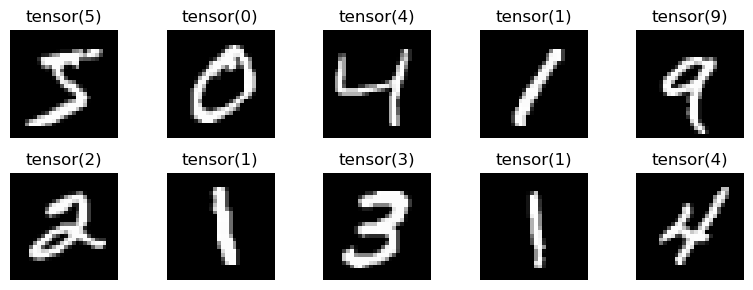

In [37]:
fig, axes = plt.subplots(2, 5, figsize=(8, 3))

for i, ax in enumerate(axes.flat):
    image, label = X_train[i], y_train[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()

In [38]:
# Define the hyperparameters
input_size = 28 * 28  # MNIST image size is 28x28
num_classes = 10

learning_rate = 0.01
batch_size = 64
num_epochs = 2

In [60]:
cnn = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(1),

    nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(1),

    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Flatten(),
    nn.Linear(6272, 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),

    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.BatchNorm1d(1024),
    nn.Linear(1024, num_classes),
)

opt = optim.SGD(cnn.parameters(), lr=learning_rate)
loss_func = F.cross_entropy

cnn

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=6272, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=1024, bias=True)
  (9): ReLU()
  (10): Linear(in_features=1024, out_features=10, bias=True)
)

In [61]:
tensor_ds = TensorDataset(X_train, y_train)
train_loader = DataLoader(tensor_ds, batch_size=batch_size, shuffle=True)

# Set model to training mode
cnn.train()

# Training loop
for epoch in range(num_epochs):
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        # Move the data and targets to the device
        Xb = Xb.to(device)
        yb = yb.to(device)
        
        # Forward pass
        pred = cnn(Xb)
        loss = loss_func(pred, yb)
        
        # Backward pass and optimization
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        # Logging
        if (batch_idx + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

Epoch [1/2], Batch [100/938], Loss: 2.2792
Epoch [1/2], Batch [200/938], Loss: 2.2162
Epoch [1/2], Batch [300/938], Loss: 1.6254
Epoch [1/2], Batch [400/938], Loss: 0.5389
Epoch [1/2], Batch [500/938], Loss: 0.4091
Epoch [1/2], Batch [600/938], Loss: 0.5891
Epoch [1/2], Batch [700/938], Loss: 0.2707
Epoch [1/2], Batch [800/938], Loss: 0.3052
Epoch [1/2], Batch [900/938], Loss: 0.6444
Epoch [2/2], Batch [100/938], Loss: 0.1626
Epoch [2/2], Batch [200/938], Loss: 0.2642
Epoch [2/2], Batch [300/938], Loss: 0.1852
Epoch [2/2], Batch [400/938], Loss: 0.3039
Epoch [2/2], Batch [500/938], Loss: 0.1742
Epoch [2/2], Batch [600/938], Loss: 0.2367
Epoch [2/2], Batch [700/938], Loss: 0.1495
Epoch [2/2], Batch [800/938], Loss: 0.2276
Epoch [2/2], Batch [900/938], Loss: 0.2827


In [62]:
def accuracy(out, y_true): 
    return (torch.argmax(out, dim=1)==y_true).float().mean()

In [63]:
accuracy(cnn(X_test), y_test)

tensor(0.9408)

In [64]:
torch.save(cnn, "../models/cnn_baseline.pth")

In [65]:
model = torch.load("../models/cnn_baseline.pth")

tensor(7)
tensor(7)
tensor([[ 0.6545, -5.1231,  2.8030,  4.0074, -4.1795, -0.4274, -8.8734, 11.4492,
         -1.1588,  3.0723]], grad_fn=<AddmmBackward0>)


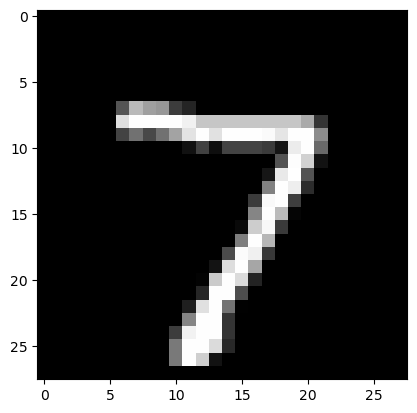

In [66]:
num = 0
print(y_test[num])
print(torch.argmax(model(X_test[num].unsqueeze(0))))
print(model(X_test[num].unsqueeze(0)))
plt.imshow(X_test[num].squeeze(), cmap="gray")